# Explaining the Data

### The data is from the Big Query Covid-19 Open Dataset. The country I am predicting for is `India`. The query to get the data is:

### The results from the query is exported to a table in my dataset, then exported the table as .csv into my bucket

# Import Data

### Initializing a Spark session for performing data analysis, including tasks like data processing, machine learning, and data exploration.

In [37]:
from pyspark.sql import SparkSession
import warnings

# Initialize Spark session
spark = SparkSession.builder.appName("COVID-19 Linear Regression").getOrCreate()
warnings.filterwarnings("ignore")

### Loading the data from a bucket

In [38]:
# Load COVID-19 data from Cloud Storage
covidData = spark.read.csv("gs://6410381/covidData/covid19.csv", header=True, inferSchema=True)

# Data Exploration

In [39]:
covidData.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- place_id: string (nullable = true)
 |-- new_confirmed: integer (nullable = true)
 |-- new_deceased: integer (nullable = true)
 |-- cumulative_confirmed: integer (nullable = true)
 |-- cumulative_deceased: integer (nullable = true)
 |-- cumulative_tested: integer (nullable = true)
 |-- new_persons_vaccinated: integer (nullable = true)
 |-- cumulative_persons_vaccinated: integer (nullable = true)
 |-- new_persons_fully_vaccinated: integer (nullable = true)
 |-- cumulative_persons_fully_vaccinated: integer (nullable = true)
 |-- new_vaccine_doses_administered: integer (nullable = true)
 |-- cumulative_vaccine_doses_administered: long (nullable = true)
 |-- cumulative_recovered: integer (nullable = true)
 |-- new_recovered: integer (nullable = true)
 |-- population: integer (nullable = true)
 |-- area_sq_km: integer (nullable = true)



In [40]:
covidData.take(1)

[Row(date=datetime.datetime(2020, 1, 1, 0, 0), place_id='ChIJe_p7JxILKDoRgZxoe7kf7ms', new_confirmed=None, new_deceased=None, cumulative_confirmed=None, cumulative_deceased=None, cumulative_tested=None, new_persons_vaccinated=None, cumulative_persons_vaccinated=None, new_persons_fully_vaccinated=None, cumulative_persons_fully_vaccinated=None, new_vaccine_doses_administered=None, cumulative_vaccine_doses_administered=None, cumulative_recovered=None, new_recovered=None, population=2663629, area_sq_km=8270)]

In [41]:
covidData.count()

678835

### Getting the number of missing values in a columns

In [42]:
from pyspark.sql.functions import col, sum

# List of column names
columns = covidData.columns

# Calculate the count of null values in each column
null_counts = [covidData.select(sum(col(column).isNull().cast("int")).alias(column)).collect()[0][0] for column in columns]

# Create a DataFrame to display the null counts
null_counts_df = spark.createDataFrame([(column, count) for column, count in zip(columns, null_counts)], ["Column", "Null Count"])

# Show the null counts
null_counts_df.show()

+--------------------+----------+
|              Column|Null Count|
+--------------------+----------+
|                date|         0|
|            place_id|       991|
|       new_confirmed|    127748|
|        new_deceased|    127748|
|cumulative_confirmed|    127068|
| cumulative_deceased|    127068|
|   cumulative_tested|    127245|
|new_persons_vacci...|    667952|
|cumulative_person...|    667915|
|new_persons_fully...|    667981|
|cumulative_person...|    667944|
|new_vaccine_doses...|    667952|
|cumulative_vaccin...|    667915|
|cumulative_recovered|    128055|
|       new_recovered|    128735|
|          population|     40631|
|          area_sq_km|     53514|
+--------------------+----------+



## Data preprocessing

### There are six columns with more 665000 missing rows, we are going to drop those columns

In [43]:
# Columns to drop
columns_to_drop = [
    "new_persons_vaccinated",
    "cumulative_persons_vaccinated",
    "new_persons_fully_vaccinated",
    "cumulative_persons_fully_vaccinated",
    "new_vaccine_doses_administered",
    "cumulative_vaccine_doses_administered"
]

# Drop the specified columns
covidData = covidData.drop(*columns_to_drop)

# Show the modified DataFrame schema
covidData.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- place_id: string (nullable = true)
 |-- new_confirmed: integer (nullable = true)
 |-- new_deceased: integer (nullable = true)
 |-- cumulative_confirmed: integer (nullable = true)
 |-- cumulative_deceased: integer (nullable = true)
 |-- cumulative_tested: integer (nullable = true)
 |-- cumulative_recovered: integer (nullable = true)
 |-- new_recovered: integer (nullable = true)
 |-- population: integer (nullable = true)
 |-- area_sq_km: integer (nullable = true)



### There are still missing values in almost every columns, the reason for these missing values at the starting period of Covid-19 is probably because there were no data being record at that time. 

In [44]:
# List of column names
columns = covidData.columns

# Calculate the count of null values in each column
null_counts = [covidData.select(sum(col(column).isNull().cast("int")).alias(column)).collect()[0][0] for column in columns]

# Create a DataFrame to display the null counts
null_counts_df = spark.createDataFrame([(column, count) for column, count in zip(columns, null_counts)], ["Column", "Null Count"])

# Show the null counts
null_counts_df.show()


+--------------------+----------+
|              Column|Null Count|
+--------------------+----------+
|                date|         0|
|            place_id|       991|
|       new_confirmed|    127748|
|        new_deceased|    127748|
|cumulative_confirmed|    127068|
| cumulative_deceased|    127068|
|   cumulative_tested|    127245|
|cumulative_recovered|    128055|
|       new_recovered|    128735|
|          population|     40631|
|          area_sq_km|     53514|
+--------------------+----------+



In [45]:
covidData.count()

678835

### Performing mean imputation on all the columns with missing values

In [47]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, Imputer
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import when, lit, mean

# Handle missing values for place_id by filling with a default value
covidData = covidData.withColumn("place_id", when(covidData["place_id"].isNull(), lit("Unknown")).otherwise(covidData["place_id"]))

# Fill missing numerical values with mean
numerical_cols = ["new_confirmed", "new_deceased", "cumulative_confirmed", "cumulative_deceased",
                  "cumulative_tested", "cumulative_recovered", "new_recovered", "population", "area_sq_km"]
imputer = Imputer(strategy="mean", inputCols=numerical_cols, outputCols=numerical_cols)
covidData = imputer.fit(covidData).transform(covidData)

# Show the updated DataFrame schema
covidData.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- place_id: string (nullable = true)
 |-- new_confirmed: integer (nullable = true)
 |-- new_deceased: integer (nullable = true)
 |-- cumulative_confirmed: integer (nullable = true)
 |-- cumulative_deceased: integer (nullable = true)
 |-- cumulative_tested: integer (nullable = true)
 |-- cumulative_recovered: integer (nullable = true)
 |-- new_recovered: integer (nullable = true)
 |-- population: integer (nullable = true)
 |-- area_sq_km: integer (nullable = true)



In [48]:
covidData.take(2)

[Row(date=datetime.datetime(2020, 1, 1, 0, 0), place_id='ChIJe_p7JxILKDoRgZxoe7kf7ms', new_confirmed=229, new_deceased=2, cumulative_confirmed=109480, cumulative_deceased=1400, cumulative_tested=1237039, cumulative_recovered=68011, new_recovered=142, population=2663629, area_sq_km=8270),
 Row(date=datetime.datetime(2020, 1, 1, 0, 0), place_id='ChIJx_LX3JMsATsRC0Cj35pdl8Q', new_confirmed=229, new_deceased=2, cumulative_confirmed=109480, cumulative_deceased=1400, cumulative_tested=1237039, cumulative_recovered=68011, new_recovered=142, population=1942288, area_sq_km=4283)]

In [49]:
# List of column names
columns = covidData.columns

# Calculate the count of null values in each column
null_counts = [covidData.select(sum(col(column).isNull().cast("int")).alias(column)).collect()[0][0] for column in columns]

# Create a DataFrame to display the null counts
null_counts_df = spark.createDataFrame([(column, count) for column, count in zip(columns, null_counts)], ["Column", "Null Count"])

# Show the null counts
null_counts_df.show()


+--------------------+----------+
|              Column|Null Count|
+--------------------+----------+
|                date|         0|
|            place_id|         0|
|       new_confirmed|         0|
|        new_deceased|         0|
|cumulative_confirmed|         0|
| cumulative_deceased|         0|
|   cumulative_tested|         0|
|cumulative_recovered|         0|
|       new_recovered|         0|
|          population|         0|
|          area_sq_km|         0|
+--------------------+----------+



### Performing Pearson Correlation to see the correlation between all features with the target attributes (new_confirmed)

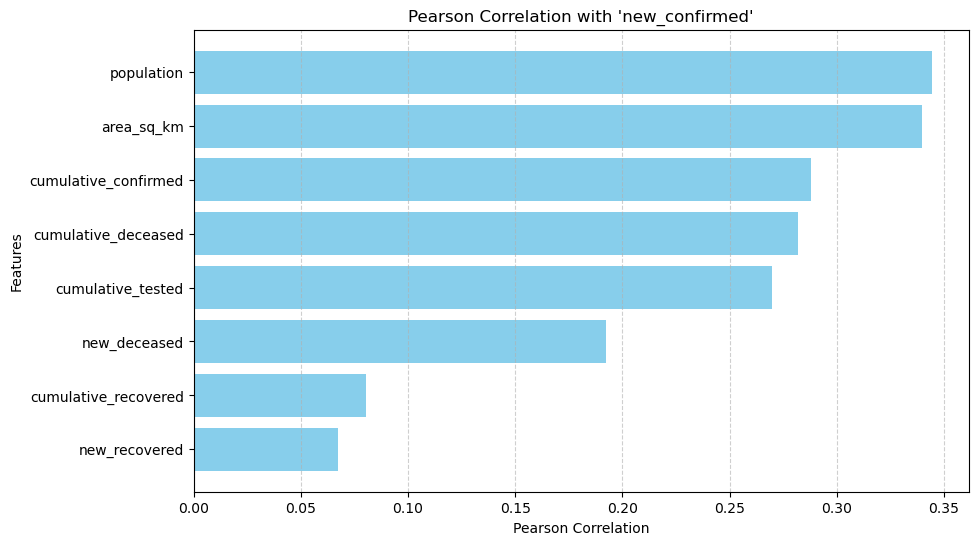

In [50]:
import matplotlib.pyplot as plt
from pyspark.ml.stat import Correlation

# Select relevant columns (features and target variable)
selected_cols = ["new_confirmed","new_deceased", "cumulative_confirmed", "cumulative_deceased", 
                 "cumulative_tested", "cumulative_recovered", "new_recovered", "population", "area_sq_km"]

# Assemble the selected columns into a single feature vector
assembler = VectorAssembler(inputCols=selected_cols, outputCol="features")
data = assembler.transform(covidData)

# Calculate Pearson correlation between features and target variable
corr_matrix = Correlation.corr(data, "features").head()
corr_values = corr_matrix[0].toArray()

# Extract correlation values with the target variable ("new_confirmed")
corr_with_target = corr_values[0]

# Create a list of column names for visualization
column_names = selected_cols[1:]  # Exclude "new_confirmed" from column names

# Zip column names with their corresponding correlation values
column_corr_pairs = list(zip(column_names, corr_with_target[1:]))

# Sort column_corr_pairs by correlation value in descending order
sorted_column_corr_pairs = sorted(column_corr_pairs, key=lambda x: abs(x[1]), reverse=False)

# Unzip the sorted pairs to obtain sorted names and values
sorted_column_names, sorted_corr_values = zip(*sorted_column_corr_pairs)

# Create a bar chart to visualize correlations
plt.figure(figsize=(10, 6))
plt.barh(sorted_column_names, sorted_corr_values, color='skyblue')
plt.xlabel("Pearson Correlation")
plt.ylabel("Features")
plt.title("Pearson Correlation with 'new_confirmed'")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


In [51]:
x = covidData
y = covidData

# Model Building

## Linear Regression

### Preparing the data

In [52]:
feature_columns = ["new_deceased", "cumulative_confirmed", "cumulative_deceased",
                  "cumulative_tested", "cumulative_recovered", "new_recovered", "population", "area_sq_km"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_data = assembler.transform(x)

### Splitting the data

In [53]:
train_data, test_data = assembled_data.randomSplit([0.8, 0.2], seed=111)

### Train linear regression model

In [54]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="new_confirmed")
lr_model = lr.fit(train_data)

23/09/11 10:24:46 WARN Instrumentation: [1e81c4fa] regParam is zero, which might cause numerical instability and overfitting.


### Predict and Evaluate the model

In [55]:
predictions = lr_model.transform(test_data)

In [56]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="new_confirmed", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

# Show the actual and predicted values
selected_cols = ["date", "new_confirmed", "prediction"]
predictions.select(*selected_cols).show()

Root Mean Squared Error (RMSE) on test data = 3271.5944586706883


+-------------------+-------------+------------------+
|               date|new_confirmed|        prediction|
+-------------------+-------------+------------------+
|2020-01-01 00:00:00|          229|116.05554293206367|
|2020-01-01 00:00:00|          229|167.00897355841053|
|2020-01-01 00:00:00|          229|174.28294382139387|
|2020-01-01 00:00:00|          229| 123.5430648468964|
|2020-01-01 00:00:00|          229|115.31305382247817|
|2020-01-01 00:00:00|          229|176.73231645172814|
|2020-01-01 00:00:00|          229|112.28438498403558|
|2020-01-01 00:00:00|          229|  174.675413466103|
|2020-01-01 00:00:00|          229| 146.6877893191152|
|2020-01-01 00:00:00|          229|215.17768990435061|
|2020-01-01 00:00:00|          229|160.86156537546236|
|2020-01-01 00:00:00|          229|133.09508727520327|
|2020-01-01 00:00:00|          229|121.61909387766092|
|2020-01-01 00:00:00|          229|157.31418543185245|
|2020-01-01 00:00:00|          229|164.63237655816772|
|2020-01-0

### Plotting the actual and predicted trend of new_confirmed using linear regression

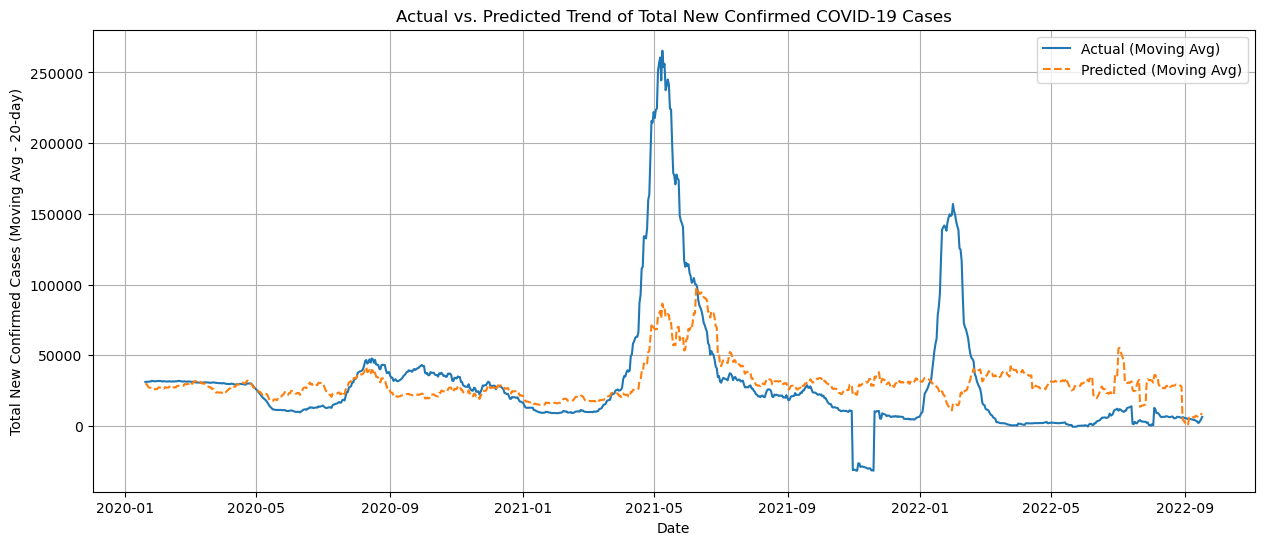

In [57]:
# Assuming 'predictions' DataFrame has columns 'date', 'new_confirmed', and 'prediction'
# Group by 'date' and sum the 'new_confirmed' values
aggregated_actual_df = predictions.groupBy("date").agg(sum("new_confirmed").alias("total_new_confirmed"))
aggregated_predicted_df = predictions.groupBy("date").agg(sum("prediction").alias("total_predicted"))

# Convert the aggregated DataFrames to Pandas
actual_df = aggregated_actual_df.orderBy("date").toPandas()
predicted_df = aggregated_predicted_df.orderBy("date").toPandas()

# Convert date column to datetime
actual_df['date'] = pd.to_datetime(actual_df['date'])
predicted_df['date'] = pd.to_datetime(predicted_df['date'])

# Calculate moving average
window_size = 20  # You can adjust this window size to control the smoothing effect
actual_df['moving_average_actual'] = actual_df['total_new_confirmed'].rolling(window=window_size).mean()
predicted_df['moving_average_predicted'] = predicted_df['total_predicted'].rolling(window=window_size).mean()

# Plot actual and predicted trends with moving average
plt.figure(figsize=(15, 6))
plt.plot(actual_df['date'], actual_df['moving_average_actual'], label="Actual (Moving Avg)")
plt.plot(predicted_df['date'], predicted_df['moving_average_predicted'], label="Predicted (Moving Avg)", linestyle='--')

plt.xlabel("Date")
plt.ylabel(f"Total New Confirmed Cases (Moving Avg - {window_size}-day)")
plt.title("Actual vs. Predicted Trend of Total New Confirmed COVID-19 Cases")
plt.legend()
plt.grid(True)
plt.show()


## Using XGBoost Model from GBT Regressor

### Preparing the data

In [58]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline

feature_columns = ["new_deceased", "cumulative_confirmed", "cumulative_deceased",
                  "cumulative_tested", "cumulative_recovered", "new_recovered", "population", "area_sq_km"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
prepared_data = assembler.transform(y)

### Splitting the data

In [59]:
train_data, test_data = prepared_data.randomSplit([0.8, 0.2], seed=111)

### Train XG Boost model

In [60]:
xgb_model = GBTRegressor(labelCol="new_confirmed", featuresCol="features")
pipeline = Pipeline(stages=[xgb_model])
model = pipeline.fit(train_data)

### Predict and Evaluate the model

In [61]:
predictions = model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="new_confirmed", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Show the actual and predicted values
selected_cols = ["date", "new_confirmed", "prediction"]
predictions.select(*selected_cols).show()

Root Mean Squared Error (RMSE): 3110.2619411158953


+-------------------+-------------+------------------+
|               date|new_confirmed|        prediction|
+-------------------+-------------+------------------+
|2020-01-01 00:00:00|          229| 227.8433614130884|
|2020-01-01 00:00:00|          229|229.42140365725106|
|2020-01-01 00:00:00|          229|  228.799990984252|
|2020-01-01 00:00:00|          229| 227.8433614130884|
|2020-01-01 00:00:00|          229| 227.8433614130884|
|2020-01-01 00:00:00|          229|  228.799990984252|
|2020-01-01 00:00:00|          229| 227.8433614130884|
|2020-01-01 00:00:00|          229|229.42140365725106|
|2020-01-01 00:00:00|          229| 227.8433614130884|
|2020-01-01 00:00:00|          229|221.94768191068624|
|2020-01-01 00:00:00|          229|228.46477408608746|
|2020-01-01 00:00:00|          229| 227.8433614130884|
|2020-01-01 00:00:00|          229| 227.8433614130884|
|2020-01-01 00:00:00|          229| 227.8433614130884|
|2020-01-01 00:00:00|          229|  228.799990984252|
|2020-01-0

### Plotting the actual and predicted trend of new_confirmed using XG Boost

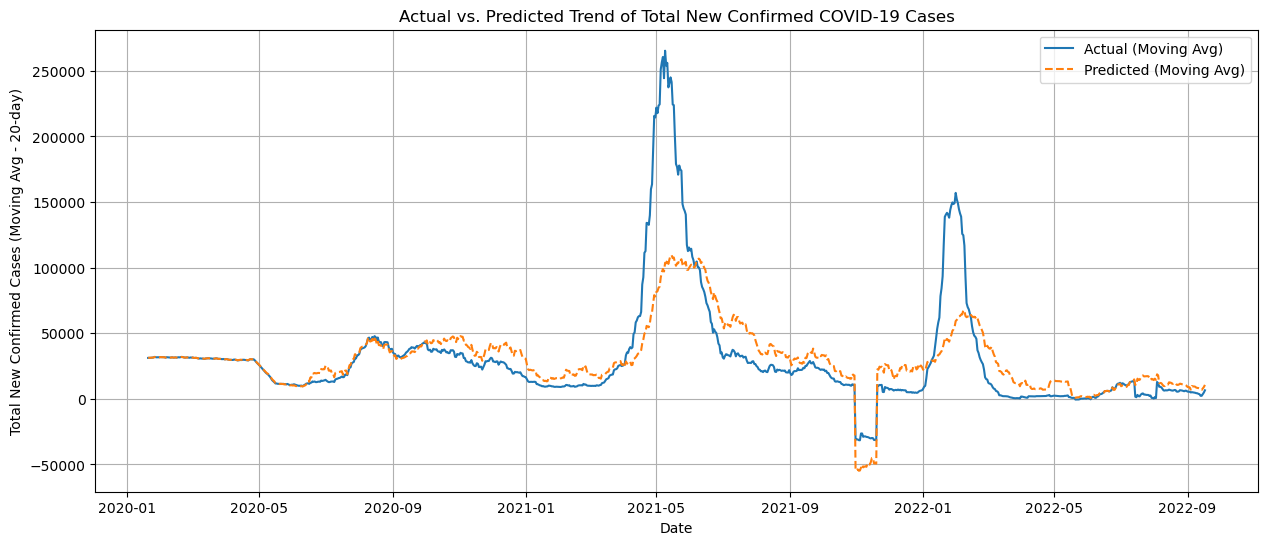

In [62]:
# Assuming 'predictions' DataFrame has columns 'date', 'new_confirmed', and 'prediction'
# Group by 'date' and sum the 'new_confirmed' values
aggregated_actual_df = predictions.groupBy("date").agg(sum("new_confirmed").alias("total_new_confirmed"))
aggregated_predicted_df = predictions.groupBy("date").agg(sum("prediction").alias("total_predicted"))

# Convert the aggregated DataFrames to Pandas
actual_df = aggregated_actual_df.orderBy("date").toPandas()
predicted_df = aggregated_predicted_df.orderBy("date").toPandas()

# Convert date column to datetime
actual_df['date'] = pd.to_datetime(actual_df['date'])
predicted_df['date'] = pd.to_datetime(predicted_df['date'])

# Calculate moving average
window_size = 20  # You can adjust this window size to control the smoothing effect
actual_df['moving_average_actual'] = actual_df['total_new_confirmed'].rolling(window=window_size).mean()
predicted_df['moving_average_predicted'] = predicted_df['total_predicted'].rolling(window=window_size).mean()

# Plot actual and predicted trends with moving average
plt.figure(figsize=(15, 6))
plt.plot(actual_df['date'], actual_df['moving_average_actual'], label="Actual (Moving Avg)")
plt.plot(predicted_df['date'], predicted_df['moving_average_predicted'], label="Predicted (Moving Avg)", linestyle='--')

plt.xlabel("Date")
plt.ylabel(f"Total New Confirmed Cases (Moving Avg - {window_size}-day)")
plt.title("Actual vs. Predicted Trend of Total New Confirmed COVID-19 Cases")
plt.legend()
plt.grid(True)
plt.show()


# Conclusion

### The XGBoost model with a lower RMSE (Root Mean Square Error) of 3110.262 performs slightly better than the Linear Regression model with an RMSE of 3271.594. This indicates that the XGBoost model provides more accurate predictions for the trend of COVID-19. XGBoost is an ensemble learning method known for its ability to capture complex relationships and patterns in the data. It combines the predictions of multiple decision trees to improve accuracy, making it well-suited for tasks like COVID-19 trend prediction, where the underlying dynamics can be intricate and non-linear. Additionally, XGBoost can handle outliers effectively, further enhancing its predictive performance.